In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [2]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [3]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [7]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

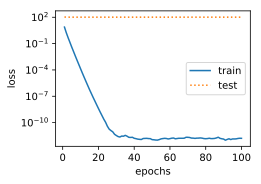

L2 norm of w: 12.904753


In [8]:
fit_and_plot(lambd=0)

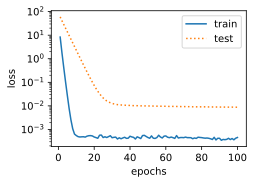

L2 norm of w: 0.042140733


In [9]:
fit_and_plot(lambd=3)

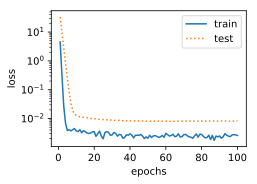

L2 norm of w: 0.029623212


In [11]:
fit_and_plot(lambd=10)

In [14]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs+1), test_ls, ['train','test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

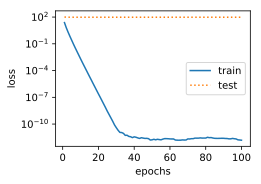

L2 norm of w: 12.641679


In [15]:
fit_and_plot_gluon(0)

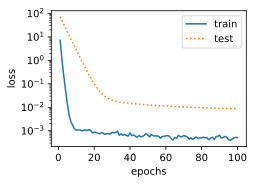

L2 norm of w: 0.043898016


In [16]:
fit_and_plot_gluon(3)